- This notebook is to check the performance of paper by using the dataset used in FM model

In [24]:
import pandas as pd
import numpy as np

from itertools import combinations

In [8]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [20]:
file_path = '../../data/Matrix/Table_S2.txt'

In [21]:
df = pd.read_csv(file_path)
df

,ID,Compound Abbreviation,Monomer Mw ( $(g/mol)$ ),XlogP3,#H-Bond Donors,#H-Bond Acceptors,Complexity,Concentration (%w/w),Polymer Mw $(g/mol)$,Compound Class
0,1,CHAPS,614.9,2.9,4,7,1030.0,20.0,614,Surfactant
1,2,Triton X-100,527.7,-2.0,1190,1704,731.0,25.0,80000,Surfactant
2,3,Alg,448.5,-3.6,2676,4348,511.0,4.0,150000,Polymer
3,4,AP,828.7,-10.6,6516,12690,1210.0,10.0,213700,Polymer
4,5,BSA,331.8,-2.3,1190,1704,391.0,40.0,66000,Protein
...,...,...,...,...,...,...,...,...,...,...
63,64,DChol,414.6,0.9,15,30,612.0,30.0,3100,Surfactant
64,65,SDS,288.4,-0.6,0,250,249.0,35.0,18000,Surfactant
65,66,Na2HPO4,141.9,0.9,1,4,46.5,16.0,142,Salt
66,67,Trag,527.7,-2.0,1190,1704,731.0,5.0,84000,Polymer


In [5]:
has_nan = df.isnull().any().any()

if has_nan:
    print("The DataFrame contains NaN values.")
else:
    print("The DataFrame does not contain NaN values.")

The DataFrame does not contain NaN values.


In [6]:
file_path1='../../data/Matrix/pairs.csv'
df_pairs = pd.read_csv(file_path1, header=None)
df_pairs.head()

,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
0,1,1,1,1,1,1,1,1,1,1,...,1,0,0,1,0,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,...,1,0,0,1,0,1,1,1,1,1
2,1,1,1,0,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,1,1
3,1,1,0,1,1,1,0,0,0,1,...,1,1,0,1,1,0,1,1,0,1
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [7]:
df_pairs.shape

(68, 68)

In [ ]:
# Construct dataset

In [22]:
# Drop 'Compound Abbreviation' and set ID as index
df_clean = df.drop(columns=['Compound Abbreviation']).set_index('ID')

# One-hot encode 'Compound Class'
df_encoded = pd.get_dummies(df_clean, columns=['Compound Class'])

In [27]:
df_encoded

,Monomer Mw ( $(g/mol)$ ),XlogP3,#H-Bond Donors,#H-Bond Acceptors,Complexity,Concentration (%w/w),Polymer Mw $(g/mol)$,Compound Class_Polymer,Compound Class_Protein,Compound Class_Salt,Compound Class_Surfactant
ID,,,,,,,,,,,
1,614.9,2.9,4,7,1030.0,20.0,614,False,False,False,True
2,527.7,-2.0,1190,1704,731.0,25.0,80000,False,False,False,True
3,448.5,-3.6,2676,4348,511.0,4.0,150000,True,False,False,False
4,828.7,-10.6,6516,12690,1210.0,10.0,213700,True,False,False,False
5,331.8,-2.3,1190,1704,391.0,40.0,66000,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...
64,414.6,0.9,15,30,612.0,30.0,3100,False,False,False,True
65,288.4,-0.6,0,250,249.0,35.0,18000,False,False,False,True
66,141.9,0.9,1,4,46.5,16.0,142,False,False,True,False


In [25]:
X_list = []
y_list = []
pair_list = []  # Optional: store which compounds were paired (for reference)

compound_ids = df_encoded.index.tolist()

for id1, id2 in combinations(compound_ids, 2):  # unique pairs only (no repeats, no self-pairs)
    feat1 = df_encoded.loc[id1].values
    feat2 = df_encoded.loc[id2].values
    
    combined_features = np.concatenate([feat1, feat2])
    label = df_pairs.loc[id1, id2]  # This assumes df_pairs is symmetric (A,B same as B,A)
    
    X_list.append(combined_features)
    y_list.append(label)
    pair_list.append((id1, id2))

# Create dataframe for X
feature_names = [f'{col}_A' for col in df_encoded.columns] + [f'{col}_B' for col in df_encoded.columns]
X = pd.DataFrame(X_list, columns=feature_names)
y = pd.Series(y_list, name='miscible')
pairs = pd.DataFrame(pair_list, columns=['ID_A', 'ID_B'])  # optional reference

In [28]:
X.columns

Index(['Monomer Mw ( $(g/mol)$ )_A', 'XlogP3_A', '#H-Bond Donors_A',
       '#H-Bond Acceptors_A', 'Complexity_A', 'Concentration (%w/w)_A',
       'Polymer Mw $(g/mol)$_A', 'Compound Class_Polymer_A',
       'Compound Class_Protein_A', 'Compound Class_Salt_A',
       'Compound Class_Surfactant_A', 'Monomer Mw ( $(g/mol)$ )_B', 'XlogP3_B',
       '#H-Bond Donors_B', '#H-Bond Acceptors_B', 'Complexity_B',
       'Concentration (%w/w)_B', 'Polymer Mw $(g/mol)$_B',
       'Compound Class_Polymer_B', 'Compound Class_Protein_B',
       'Compound Class_Salt_B', 'Compound Class_Surfactant_B'],
      dtype='object')

In [29]:
X.shape

(2278, 22)

In [35]:
X.columns

Index(['Monomer Mw ( $(g/mol)$ )_A', 'XlogP3_A', '#H-Bond Donors_A',
       '#H-Bond Acceptors_A', 'Complexity_A', 'Concentration (%w/w)_A',
       'Polymer Mw $(g/mol)$_A', 'Compound Class_Polymer_A',
       'Compound Class_Protein_A', 'Compound Class_Salt_A',
       'Compound Class_Surfactant_A', 'Monomer Mw ( $(g/mol)$ )_B', 'XlogP3_B',
       '#H-Bond Donors_B', '#H-Bond Acceptors_B', 'Complexity_B',
       'Concentration (%w/w)_B', 'Polymer Mw $(g/mol)$_B',
       'Compound Class_Polymer_B', 'Compound Class_Protein_B',
       'Compound Class_Salt_B', 'Compound Class_Surfactant_B'],
      dtype='object')

In [32]:
X

,Monomer Mw ( $(g/mol)$ )_A,XlogP3_A,#H-Bond Donors_A,#H-Bond Acceptors_A,Complexity_A,Concentration (%w/w)_A,Polymer Mw $(g/mol)$_A,Compound Class_Polymer_A,Compound Class_Protein_A,Compound Class_Salt_A,...,XlogP3_B,#H-Bond Donors_B,#H-Bond Acceptors_B,Complexity_B,Concentration (%w/w)_B,Polymer Mw $(g/mol)$_B,Compound Class_Polymer_B,Compound Class_Protein_B,Compound Class_Salt_B,Compound Class_Surfactant_B
0,614.9,2.9,4,7,1030.0,20.0,614,False,False,False,...,-2.0,1190,1704,731.0,25.0,80000,False,False,False,True
1,614.9,2.9,4,7,1030.0,20.0,614,False,False,False,...,-3.6,2676,4348,511.0,4.0,150000,True,False,False,False
2,614.9,2.9,4,7,1030.0,20.0,614,False,False,False,...,-10.6,6516,12690,1210.0,10.0,213700,True,False,False,False
3,614.9,2.9,4,7,1030.0,20.0,614,False,False,False,...,-2.3,1190,1704,391.0,40.0,66000,False,True,False,False
4,614.9,2.9,4,7,1030.0,20.0,614,False,False,False,...,-5.0,7089,16497,998.0,1.0,671875,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2273,288.4,-0.6,0,250,249.0,35.0,18000,False,False,False,...,-2.0,1190,1704,731.0,5.0,84000,True,False,False,False
2274,288.4,-0.6,0,250,249.0,35.0,18000,False,False,False,...,-9.5,12785,28521,1670.0,4.0,1000000,True,False,False,False
2275,141.9,0.9,1,4,46.5,16.0,142,False,False,True,...,-2.0,1190,1704,731.0,5.0,84000,True,False,False,False
2276,141.9,0.9,1,4,46.5,16.0,142,False,False,True,...,-9.5,12785,28521,1670.0,4.0,1000000,True,False,False,False


In [34]:
X.to_csv('X_misibility_paper.csv', index=False)

In [18]:
68 * (68 - 1) / 2 

2278.0

In [30]:
pairs

,ID_A,ID_B
0,1,2
1,1,3
2,1,4
3,1,5
4,1,6
...,...,...
2273,65,67
2274,65,68
2275,66,67
2276,66,68


AUC-ROC: 0.792


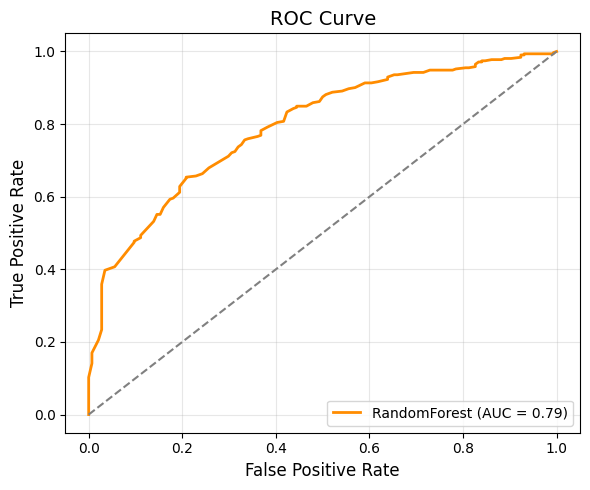

In [31]:
# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train RandomForest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict probabilities
y_probs = clf.predict_proba(X_test)[:, 1]  # probability of class 1

# Calculate ROC AUC
auc = roc_auc_score(y_test, y_probs)
print(f"AUC-ROC: {auc:.3f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'RandomForest (AUC = {auc:.2f})', color='darkorange', lw=2)
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=14)
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
